# EX.1

![ex1.png](./ex1.PNG)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm

In [2]:
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score

In [5]:
def abline(ax, b = 0, m = 1, *args , **kwargs):
    "Add a line with slope m and intercept b to ax"
    xlim = ax.get_xlim()
    ylim = [m * xlim[0] + b, m * xlim[1] + b]
    ax.plot(xlim , ylim , *args , **kwargs)

In [6]:
Auto = load_data('Auto')
Auto.columns

Index(['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'year', 'origin'],
      dtype='object')

In [7]:
Auto.shape

(392, 8)

In [8]:
X = MS(['horsepower']).fit_transform(Auto)
X

,intercept,horsepower
name,,
chevrolet chevelle malibu,1.0,130
buick skylark 320,1.0,165
plymouth satellite,1.0,150
amc rebel sst,1.0,150
ford torino,1.0,140
...,...,...
ford mustang gl,1.0,86
vw pickup,1.0,52
dodge rampage,1.0,84


In [9]:
y = Auto['mpg']
# OLS specificies the model (Ordinary Least Squares) then model.fit() does the actual fitting
model = sm.OLS(y, X)
result = model.fit()
summarize(result)

,coef,std err,t,P>|t|
intercept,39.9359,0.717,55.660,0.0
horsepower,-0.1578,0.006,-24.489,0.0


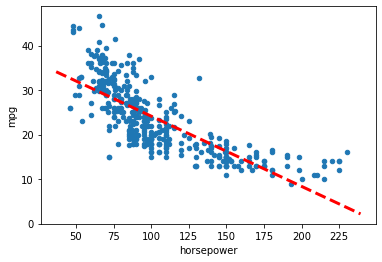

In [10]:
ax = Auto.plot.scatter('horsepower', 'mpg')
abline(ax, result.params.iloc[0], result.params.iloc[1], 'r--', linewidth = 3)

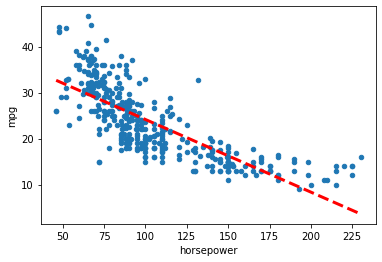

In [11]:
x_vals_lin = np.linspace(Auto['horsepower'].min(), Auto['horsepower'].max(), 100)
x_poly_lin = MS(['horsepower']).fit(Auto).transform(pd.DataFrame({'horsepower': x_vals_lin}))

# Predict using the same transformation
y_pred_lin = result.predict(x_poly_lin)

# Plot
Auto.plot.scatter('horsepower', 'mpg')
plt.plot(x_vals_lin, y_pred_lin, 'r--', linewidth = 3)
plt.show()

In [12]:
result.rsquared

0.6059482578894348

With a relatively high value of $R^2 = 0.606$, we can find an inverse proportionality between horsepower and mpg (miles per gallon). This result intuitively makes sense: a more powerful engine tends to consume an higher amount of fuel and so it makes a lower number of miles with a gallon of fuel.

In [13]:
# Add the new data with horsepower 98
new_df = pd.DataFrame({'horsepower':[98]})
newX = MS(['horsepower']).fit_transform(new_df)

In [14]:
new_predictions = result.get_prediction(newX)
# Predicted mean simply computes the predicted value of y using the trained values of b and w and the newX
new_predictions.predicted_mean

array([24.46707715])

In [15]:
# Computes the confidence intervals
new_predictions.conf_int(alpha=0.05)

array([[23.97307896, 24.96107534]])

In [16]:
# Computes the confidence intervals, which takes into account both the uncertainty of the mean and the variability of the individual data points --> wider range
new_predictions.conf_int(obs = True, alpha=0.05)

array([[14.80939607, 34.12475823]])

Both centered around the predicted mean $24.467$.

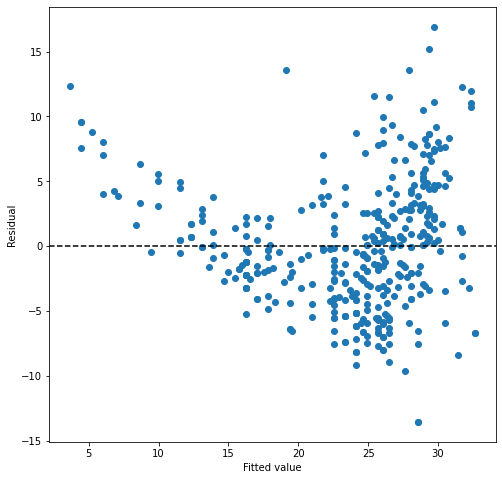

In [17]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(result.fittedvalues , result.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

A pattern can be inferred from the residuals, maybe the underlying dependency is quadratic.

115

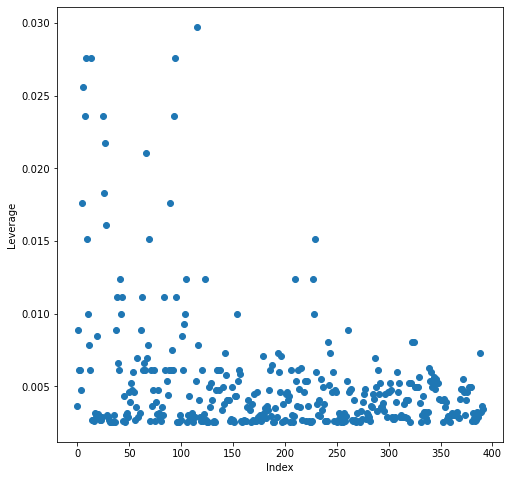

In [18]:
infl = result.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
#Leverage statistics can be computed for any number of predictors using the hat_matrix_diag attribute of the value returned by the get_influence() method.
ax.scatter(np.arange(X.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
# maximized over the entire array to determine which observation has the largest leverage statistic.
np.argmax(infl.hat_matrix_diag)

In [19]:
Auto.iloc[115]

mpg               16.0
cylinders          8.0
displacement     400.0
horsepower       230.0
weight          4278.0
acceleration       9.5
year              73.0
origin             1.0
Name: pontiac grand prix, dtype: float64

In [20]:
new_df = pd.DataFrame({'horsepower':[230]})
newX = MS(['horsepower']).fit_transform(new_df)
new_predictions = result.get_prediction(newX)
# Predicted mean simply computes the predicted value of y using the trained values of b and w and the newX
new_predictions.predicted_mean

array([3.63157235])

In [21]:
X = MS([poly('horsepower', degree=2)]).fit_transform(Auto)
model3 = sm.OLS(y, X)
result3 = model3.fit()
summarize(result3)

,coef,std err,t,P>|t|
intercept,23.4459,0.221,106.130,0.0
"poly(horsepower, degree=2)[0]",-120.1377,4.374,-27.467,0.0
"poly(horsepower, degree=2)[1]",44.0895,4.374,10.080,0.0


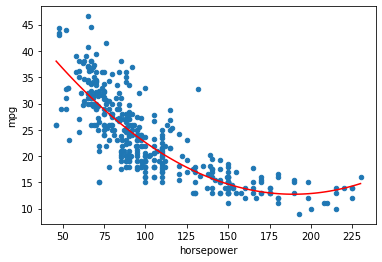

In [22]:
x_vals = np.linspace(Auto['horsepower'].min(), Auto['horsepower'].max(), 100)
x_poly = MS([poly('horsepower', degree=2)]).fit(Auto).transform(pd.DataFrame({'horsepower': x_vals}))

# Predict using the same transformation
y_pred = result3.predict(x_poly)

# Plot
Auto.plot.scatter('horsepower', 'mpg')
plt.plot(x_vals, y_pred, color='red')
plt.show()

In [23]:
result3.params

intercept                         23.445918
poly(horsepower, degree=2)[0]   -120.137744
poly(horsepower, degree=2)[1]     44.089528
dtype: float64

In [24]:
anova_lm(result , result3)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,390.0,9385.915872,0.0,NaN,NaN,NaN
1,389.0,7442.029412,1.0,1943.88646,101.608283,2.196340e-21


The quadratic fit proves better than the linear.

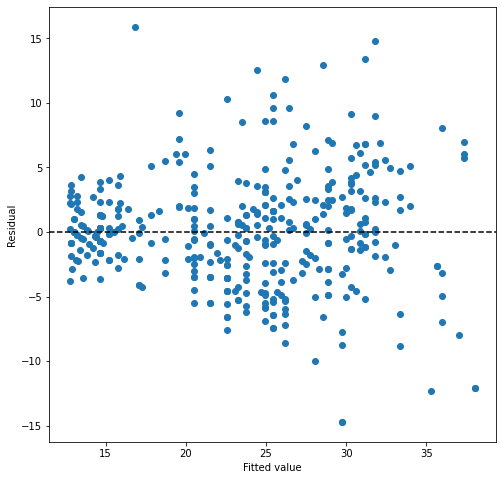

In [25]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(result3.fittedvalues , result3.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

Now the residues no longer show a U-shaped behaviour like it did for the linear case.

115

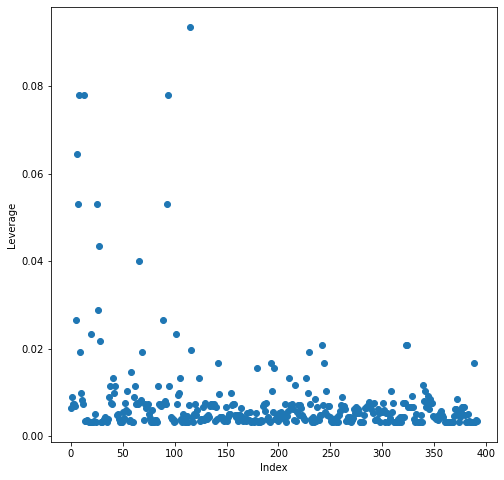

In [26]:
infl3 = result3.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
#Leverage statistics can be computed for any number of predictors using the hat_matrix_diag attribute of the value returned by the get_influence() method.
ax.scatter(np.arange(X.shape[0]), infl3.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
# maximized over the entire array to determine which observation has the largest leverage statistic.
np.argmax(infl3.hat_matrix_diag)

![ex2_1.png](./ex2_1.PNG)
![ex2_2.png](./ex2_2.PNG)

In [27]:
X2 = MS(Auto.columns.drop(['mpg'])).fit_transform(Auto)
X2

,intercept,cylinders,displacement,horsepower,weight,acceleration,year,origin
name,,,,,,,,
chevrolet chevelle malibu,1.0,8,307.0,130,3504,12.0,70,1
buick skylark 320,1.0,8,350.0,165,3693,11.5,70,1
plymouth satellite,1.0,8,318.0,150,3436,11.0,70,1
amc rebel sst,1.0,8,304.0,150,3433,12.0,70,1
ford torino,1.0,8,302.0,140,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
ford mustang gl,1.0,4,140.0,86,2790,15.6,82,1
vw pickup,1.0,4,97.0,52,2130,24.6,82,2
dodge rampage,1.0,4,135.0,84,2295,11.6,82,1


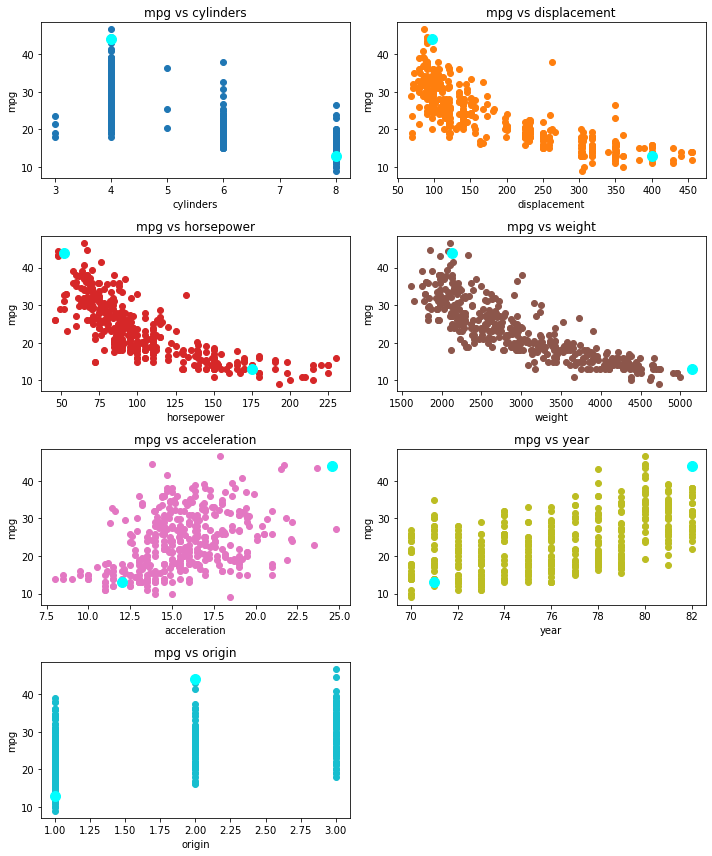

In [28]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
axes = axes.flatten()  # Flatten for easy indexing
highlight_idx = [43, 388]
point = Auto.iloc[highlight_idx]
colors = plt.colormaps.get_cmap('tab10').resampled(len(Auto.columns.drop('mpg')))

for i, col in enumerate(Auto.columns.drop('mpg')):
    ax = axes[i]
    ax.scatter(Auto[col], Auto['mpg'], color = colors(i), label=col)
    ax.set_title(f'mpg vs {col}')
    ax.set_ylabel('mpg')
    ax.set_xlabel(col)
    #ax.legend()
    
    # Highlight the points with high leverage and residual
    ax.scatter(point[col], point['mpg'], color='cyan', s=100, label=f'Index {highlight_idx}')
    
    
# Hide any unused subplots (if you have more axes than plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    

plt.tight_layout()
plt.show()

To use anova_lm we need to use statsmodels.formula.api.ols here imported as ols instead of the lower level statsmodels.api.OLS since it does store the design_info object which is needed in subsequent calculations. 

ols needs a formula which comes written in this form: 
*response_variable ~ predictor1 + predictor2 + predictor3 + ...*

In [30]:
y = Auto['mpg']
# Build the formula for regression
formula = 'mpg ~ ' + ' + '.join(Auto.columns.drop('mpg'))
# Fit the model using formula API
result_all = ols(formula, data=Auto).fit()
summarize(result_all)

,coef,std err,t,P>|t|
Intercept,-17.2184,4.644,-3.707,0.000
cylinders,-0.4934,0.323,-1.526,0.128
displacement,0.0199,0.008,2.647,0.008
horsepower,-0.0170,0.014,-1.230,0.220
weight,-0.0065,0.001,-9.929,0.000
acceleration,0.0806,0.099,0.815,0.415
year,0.7508,0.051,14.729,0.000
origin,1.4261,0.278,5.127,0.000


In [31]:
print(result_all.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Thu, 28 Aug 2025   Prob (F-statistic):          2.04e-139
Time:                        12:39:57   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -17.2184      4.644     -3.707   

p-values of cylinders, acceleration, horsepower and displacement (though slightly) are above 0.05

In [32]:
anova_lm(result_all)

,df,sum_sq,mean_sq,F,PR(>F)
cylinders,1.0,14403.083079,14403.083079,1300.683788,2.319511e-125
displacement,1.0,1073.344025,1073.344025,96.929329,1.530906e-20
horsepower,1.0,403.408069,403.408069,36.430140,3.731128e-09
weight,1.0,975.724953,975.724953,88.113748,5.544461e-19
acceleration,1.0,0.966071,0.966071,0.087242,7.678728e-01
year,1.0,2419.120249,2419.120249,218.460900,1.875281e-39
origin,1.0,291.134494,291.134494,26.291171,4.665681e-07
Residual,384.0,4252.212530,11.073470,NaN,NaN


Null Hypothesis of the anova: All regression coefficients (except the intercept) are zero — i.e., none of the predictors have a significant effect on the response variable.
So if PR(>F) is small (typically < 0.05), we reject the null hypothesis, concluding that at least one predictor significantly contributes to the model.

All parameters have a $p< 0.05$ except for the acceleration, which can the be excluded from the model without losing much explanatory power.

The year coefficient is positive $0.75$ and it tells us that newer cars tend to have an higher mpg (lower fuel consumptions) than older models.result_all.resid

In [33]:
result_all.resid

name
chevrolet chevelle malibu    2.999041
buick skylark 320            1.000701
plymouth satellite           2.759553
amc rebel sst                0.938094
ford torino                  2.032822
                               ...   
ford mustang gl             -1.319554
vw pickup                    9.535428
dodge rampage                0.863674
ford ranger                 -1.350244
chevy s-10                   2.271079
Length: 392, dtype: float64

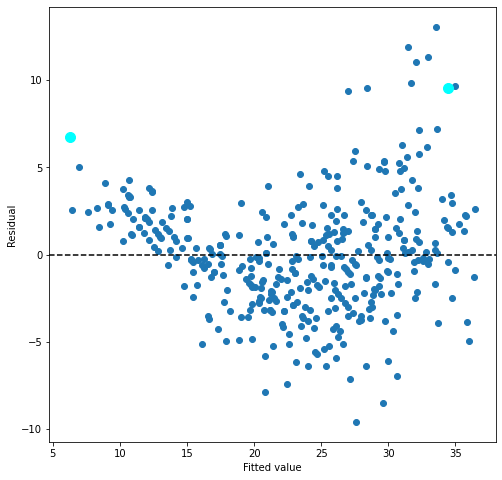

In [34]:
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(result_all.fittedvalues , result_all.resid)
ax.scatter(result_all.fittedvalues.iloc[highlight_idx] , result_all.resid.iloc[highlight_idx], color='cyan', s=100, label=f'Index {highlight_idx}')
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.axhline(0, c='k', ls='--');

The residuals are U-shaped, probably indicating an higher order correlation between the input and the response mpg.

13

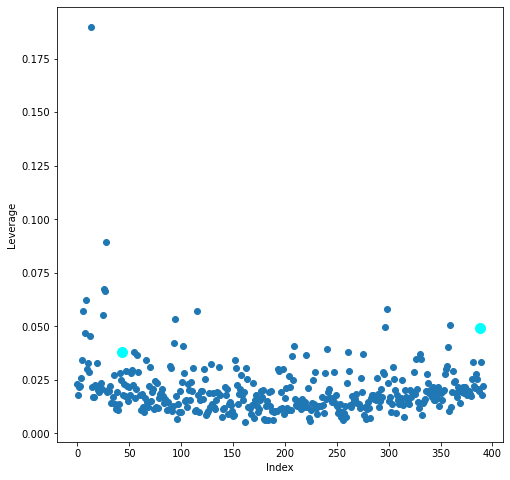

In [35]:
infl_all = result_all.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
#Leverage statistics can be computed for any number of predictors using the hat_matrix_diag attribute of the value returned by the get_influence() method.
ax.scatter(np.arange(X2.shape[0]), infl_all.hat_matrix_diag)
ax.scatter(np.arange(X2.shape[0])[highlight_idx] , infl_all.hat_matrix_diag[highlight_idx], color='cyan', s=100, label=f'Index {highlight_idx}')
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
# maximized over the entire array to determine which observation has the largest leverage statistic.
np.argmax(infl_all.hat_matrix_diag)

In [36]:
n = X2.shape[0]
p = X2.shape[1] - 1  # subtract intercept
leverage = infl_all.hat_matrix_diag

leverage_threshold = 2 * (p + 1) / n
high_leverage_points = np.where(leverage > leverage_threshold)[0]

print("High leverage points (index positions):", high_leverage_points)
print("Leverage values of these points:", leverage[high_leverage_points])

High leverage points (index positions): [  6   7   8  12  13  25  26  27  28  93  94 115 209 297 298 359 388]
Leverage values of these points: [0.05732775 0.0469958  0.06244917 0.0453853  0.18991289 0.05550071
 0.06736993 0.06667349 0.08954137 0.04221313 0.05330274 0.05703622
 0.04082394 0.04963809 0.05795377 0.05047094 0.04917182]


In [37]:
#Raw residuals aren't always directly comparable across data points because they may have different variances. So instead, we use:
# Standardized residuals: residuals divided by their estimated standard deviation.
# Studentized residuals: similar but better for detecting outliers, especially when leverage varies.

studentized_residuals = infl_all.resid_studentized_external
high_resid_points = np.where(np.abs(studentized_residuals) > 2)[0]

print("High residual points (indices):", high_resid_points)
print("Studentized residuals of these points:", studentized_residuals[high_resid_points])

High residual points (indices): [ 43 107 110 153 164 242 245 268 307 320 322 323 324 325 327 331 381 388]
Studentized residuals of these points: [ 2.07799754 -2.17121062 -2.94647299 -2.2818623  -2.40172248  3.39006834
  2.17527128 -2.59818918  2.99329081  4.0295372   2.18535661  3.49482317
  3.69024588  2.8766929   2.95777248 -2.14494437  2.95321898  2.96838467]


Points with both and high leverage and high residual

In [38]:
high_lev_and_res = np.intersect1d(high_leverage_points, high_resid_points)
print("High leverage and residual points (indices):", high_lev_and_res)

High leverage and residual points (indices): [388]


## Transformations

Guess: mpg has a quadratic dependence on horsepower, weight, acceleration and displacement, following the plot.Auto = load_data('Auto')

In [73]:
Auto_transf = load_data('Auto')

Auto_transf['horsepower2'] = Auto_transf['horsepower']**2
Auto_transf['weight2'] = Auto_transf['weight']**2 
Auto_transf['acceleration2'] = Auto_transf['acceleration']**2
Auto_transf['displacement2'] = Auto_transf['displacement']**2

In [74]:
formula_lin = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + origin'
# Fit the model using formula API
result_all_lin = ols(formula_lin, data=Auto_transf).fit()
print(result_all_lin.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Thu, 28 Aug 2025   Prob (F-statistic):          2.04e-139
Time:                        12:57:56   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      -17.2184      4.644     -3.707   

In [75]:
formula_quad = 'mpg ~ cylinders + displacement2 + horsepower2 + weight2 + acceleration2 + year + origin'
result_all_quad = ols(formula_quad, data=Auto_transf).fit()
print(result_all_quad.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     222.6
Date:                Thu, 28 Aug 2025   Prob (F-statistic):          6.37e-131
Time:                        12:58:10   Log-Likelihood:                -1043.5
No. Observations:                 392   AIC:                             2103.
Df Residuals:                     384   BIC:                             2135.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -25.4628      4.442     -5.732

displcement and weight and now fit perfectly, acceleration is slightly above 0.05, horsepower worsened a bit.

![aic_bic.PNG](./aic_bic.PNG)

In [76]:
print("AIC difference:", result_all_quad.aic - result_all_lin.aic)
print("BIC difference:", result_all_quad.bic - result_all_lin.bic)

AIC difference: 40.057437441612365
BIC difference: 40.057437441612365


A difference > 10 is already considered very strong evidence in favor of the model with the lower AIC/BIC. A difference of ~40 is overwhelming evidence that the quadratic model is substantially better than the linear model.

In [77]:
Auto_transf['horsepower_log'] = np.log(Auto_transf['horsepower'])
# Auto_transf['weight_log'] = np.log(Auto['weight'])
# Auto_transf['acceleration_log'] = np.log(Auto['acceleration'])
# Auto_transf['displacement_log'] = np.log(Auto['displacement'])
# Auto_transf['cylinders_log'] = np.log(Auto['cylinders'])
# Auto_transf['year_log'] = np.log(Auto['year'])
# Auto_transf['origin_log'] = np.log(Auto['origin'])

In [78]:
formula_log = 'mpg ~ cylinders + displacement2 + horsepower_log + weight2 + acceleration2 + year + origin'
result_all_log = ols(formula=formula_log, data=Auto_transf).fit()
print(result_all_log.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     276.9
Date:                Thu, 28 Aug 2025   Prob (F-statistic):          8.75e-146
Time:                        12:58:19   Log-Likelihood:                -1008.5
No. Observations:                 392   AIC:                             2033.
Df Residuals:                     384   BIC:                             2065.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         32.9356      7.865      4.

In [79]:
print("AIC difference:", result_all_quad.aic - result_all_log.aic)
print("BIC difference:", result_all_quad.bic - result_all_log.bic)

AIC difference: 70.07112737745547
BIC difference: 70.07112737745547


Large improvement wrt the all quadratic model

With this combined logarithmic and quadratic behaviour, the pvalue of all parameters is below the 0.05 threshold and the $R^2$ value is really high.

## Correlation

In [29]:
X2.corr()

,intercept,cylinders,displacement,horsepower,weight,acceleration,year,origin
intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cylinders,NaN,1.000000,0.950823,0.842983,0.897527,-0.504683,-0.345647,-0.568932
displacement,NaN,0.950823,1.000000,0.897257,0.932994,-0.543800,-0.369855,-0.614535
horsepower,NaN,0.842983,0.897257,1.000000,0.864538,-0.689196,-0.416361,-0.455171
weight,NaN,0.897527,0.932994,0.864538,1.000000,-0.416839,-0.309120,-0.585005
acceleration,NaN,-0.504683,-0.543800,-0.689196,-0.416839,1.000000,0.290316,0.212746
year,NaN,-0.345647,-0.369855,-0.416361,-0.309120,0.290316,1.000000,0.181528
origin,NaN,-0.568932,-0.614535,-0.455171,-0.585005,0.212746,0.181528,1.000000


In [47]:
# formula_corr = 'mpg ~ cylinders + displacement + horsepower + weight + acceleration + year + origin + year:weight + horsepower:weight'
# interaction_model = ols(formula=formula_corr, data=Auto).fit()
# print(interaction_model.summary())

In [48]:
X2 = Auto[Auto.columns.drop('mpg')]
y = Auto['mpg']
model_lin = LinearRegression()
model_lin.fit(X2, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


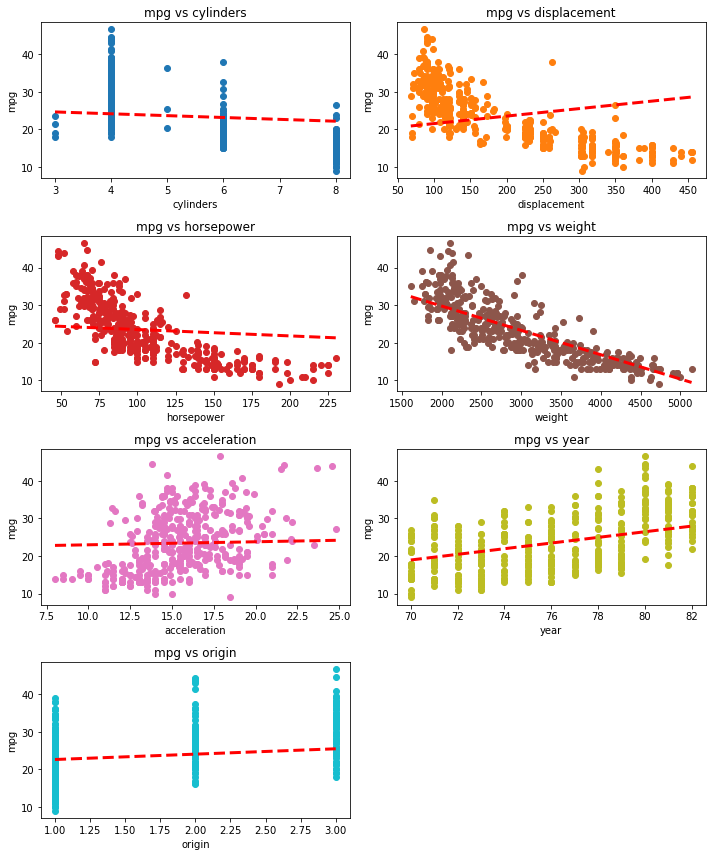

In [49]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
axes = axes.flatten()  # Flatten for easy indexing
feature_means = X2.mean()
colors = plt.colormaps.get_cmap('tab10').resampled(len(Auto.columns.drop('mpg')))

for i, col in enumerate(Auto.columns.drop('mpg')):
    ax = axes[i]
    feature_range = np.linspace(X2[col].min(), X2[col].max(), 392).reshape(-1, 1)
    fixed_params = Auto.columns.drop(['mpg', col])
    x_vals_lin = pd.DataFrame({col: [feature_means[col]] * 392 for col in Auto.columns.drop('mpg')})
    x_vals_lin[col] = feature_range
    
    ax.scatter(Auto[col], Auto['mpg'], color = colors(i), label=col)
    ax.set_title(f'mpg vs {col}')
    ax.set_ylabel('mpg')
    ax.set_xlabel(col)
    # Predict using the same transformation
    y_pred_lin = model_lin.predict(x_vals_lin)
    ax.plot(feature_range, y_pred_lin, 'r--', linewidth = 3)
    

# Hide any unused subplots (if you have more axes than plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

In [50]:
X2 = Auto[Auto.columns.drop('mpg')]
y = Auto['mpg']
model_sq = make_pipeline(PolynomialFeatures(2), LinearRegression())
model_sq.fit(X2, y)

,steps,"[('polynomialfeatures', ...), ('linearregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,degree,2
,interaction_only,False
,include_bias,True
,order,'C'
,fit_intercept,True
,copy_X,True
,tol,1e-06


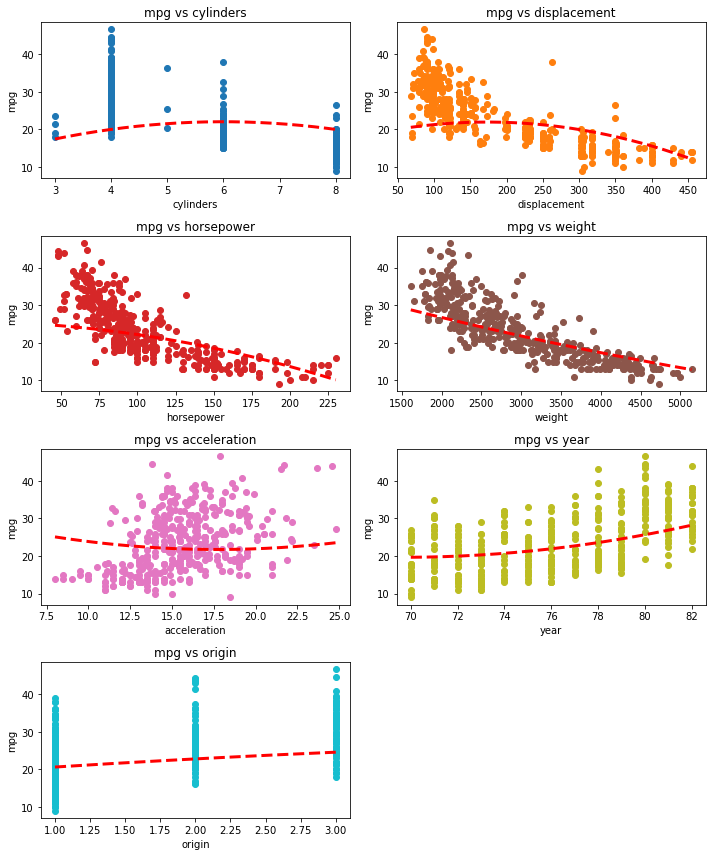

In [51]:
fig, axes = plt.subplots(4, 2, figsize=(10, 12))
axes = axes.flatten()  # Flatten for easy indexing
feature_means = X2.mean()
colors = plt.colormaps.get_cmap('tab10').resampled(len(Auto.columns.drop('mpg')))

for i, col in enumerate(Auto.columns.drop('mpg')):
    ax = axes[i]
    feature_range = np.linspace(X2[col].min(), X2[col].max(), 392).reshape(-1, 1)
    fixed_params = Auto.columns.drop(['mpg', col])
    x_vals_sq = pd.DataFrame({col: [feature_means[col]] * len(feature_range) for col in Auto.columns.drop('mpg')})
    x_vals_sq[col] = feature_range
    
    ax.scatter(Auto[col], Auto['mpg'], color = colors(i), label=col)
    ax.set_title(f'mpg vs {col}')
    ax.set_ylabel('mpg')
    ax.set_xlabel(col)
    # Predict using the same transformation
    y_pred_sq = model_sq.predict(x_vals_sq)
    ax.plot(feature_range, y_pred_sq, 'r--', linewidth = 3)
    

# Hide any unused subplots (if you have more axes than plots)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()